<div style="text-align: center; font-size: 30pt; font-weight: bold; margin: 1em 0em 1em 0em">Visualization</div>

In [1]:
import sys, os

In [2]:
sys.path.append(os.path.abspath('../autoencoders'))

In [3]:
# "Magic" commands for automatic reloading of module, perfect for prototyping
%reload_ext autoreload
%autoreload 2

import wasserstein
import proteins
import visualization

In [4]:
import matplotlib.pyplot as plt

In [5]:
# LaTeX rendering in graphs
try:
    plt.rc('text', usetex=True)
except:
    pass

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [69]:
import numpy as np
import pandas as pd

import torch

# Paths

In [7]:
ROOT = '../'

In [8]:
MODULE_PATH = ROOT + 'autoencoders/'
DATA_PATH = ROOT + 'data/'
NOTEBOOK_PATH = ROOT + 'notebooks/'
MODELS_PATH = ROOT + 'models/'
GRAPHICS_PATH = ROOT + 'graphics/'

# Loading the model

In [9]:
model = proteins.WassersteinAutoEncoder(ksi=10., hidden_dimension=10)
model.load_state_dict(torch.load(MODELS_PATH + 'wae-h=10.weights', map_location='cpu'))

In [21]:
model2 = proteins.WassersteinAutoEncoder(ksi=10., hidden_dimension=2)
model2.load_state_dict(torch.load(MODELS_PATH + 'wae.weights', map_location='cpu'))

# Dataset

In [10]:
complete_set = np.load(DATA_PATH + 'pgm-dataset.npy')

In [11]:
prot = visualization.Protein(complete_set[0])

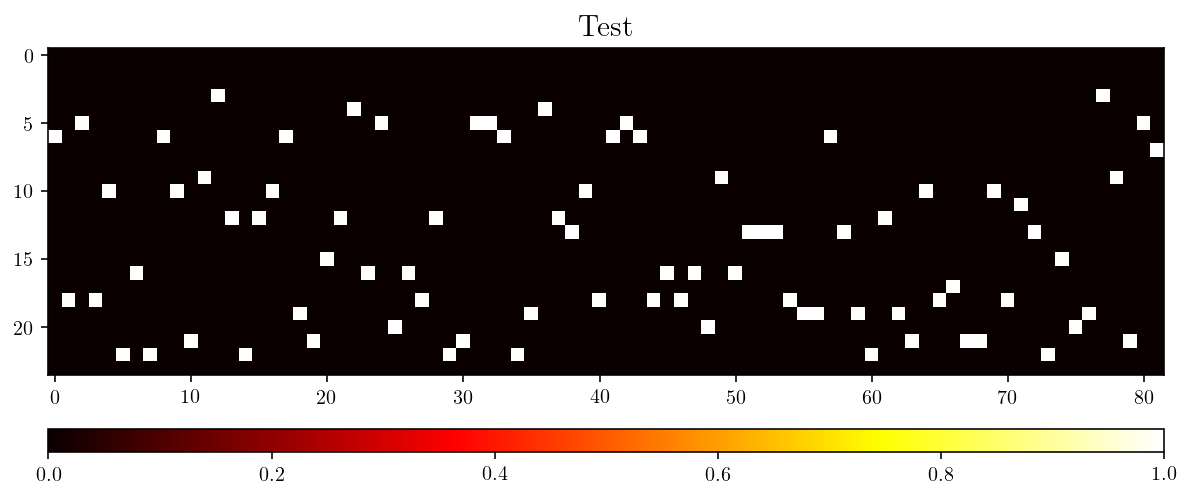

In [12]:
prot.plot_sequence(title='Test', save=GRAPHICS_PATH+'test-visualization.pdf')

In [67]:
with torch.no_grad():
    reconstruction, latent = model(torch.Tensor(complete_set))

In [68]:
with torch.no_grad():
    reconstruction2, latent2 = model2(torch.Tensor(complete_set))

In [71]:
reconstruction = np.array(reconstruction)

In [72]:
reconstruction2 = np.array(reconstruction2)

In [ ]:
accuracy = pd.DataFrame(columns=[2, 10])

for i in range(len(reconstruction)):
    p = complete_set[i].reshape(24, 82)
    r = reconstruction[i].reshape(24, 82)
    r2 = reconstruction2[i].reshape(24, 82)
    
    accuracy.loc[i, 2] = (r2.argmax(axis=0) == p.argmax(axis=0)).sum() * 100 / 82
    accuracy.loc[i, 10] = (r.argmax(axis=0) == p.argmax(axis=0)).sum() * 100 / 82

In [74]:
accuracy.describe()

,2,10
count,21410.000000,21409.000000
unique,65.000000,65.000000
top,97.560976,96.341463
freq,1689.000000,1564.000000


In [49]:
i = -1

16
Accuracy h=10 : 37.80487804878049
Accuracy h=2  : 40.24390243902439


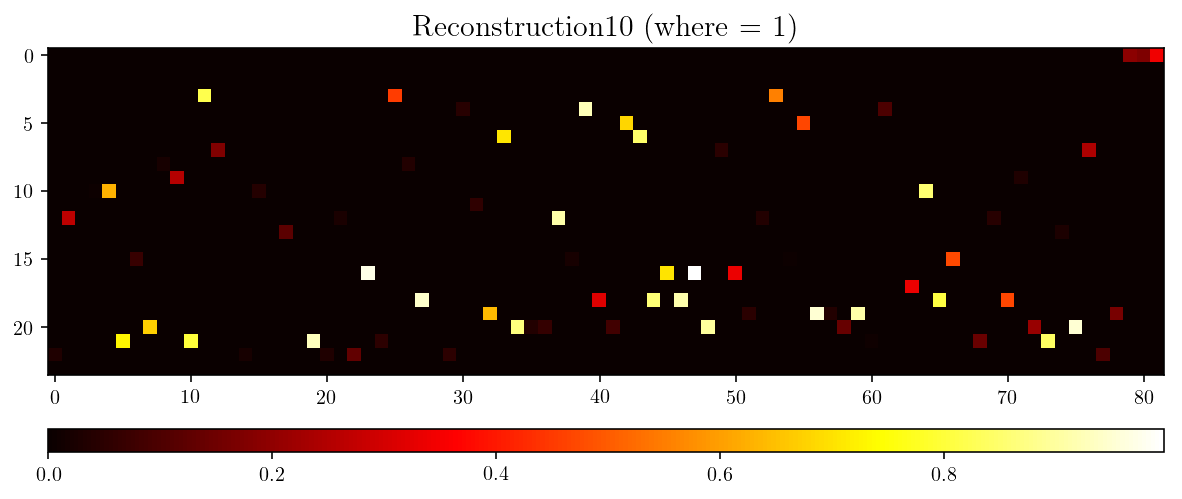

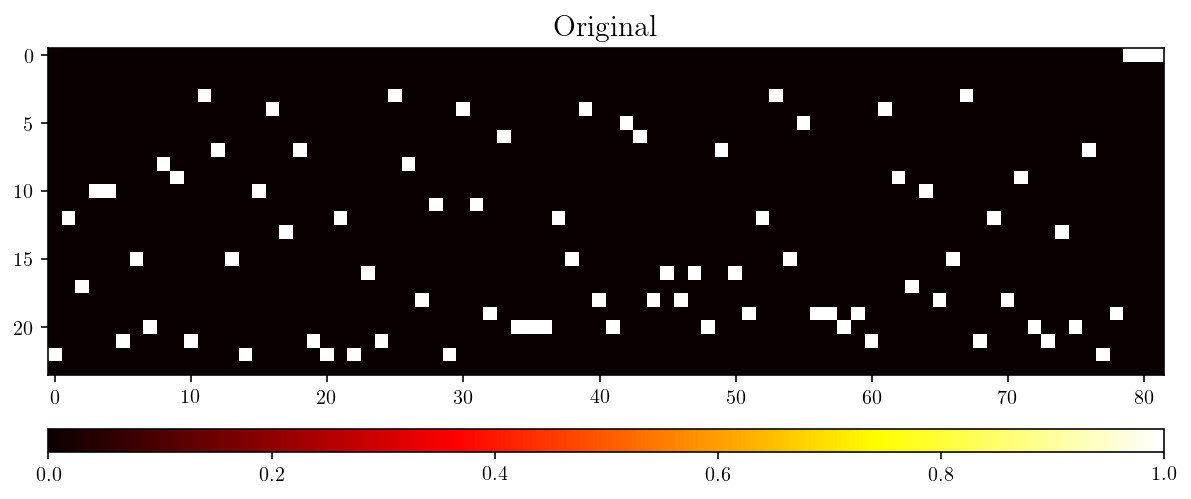

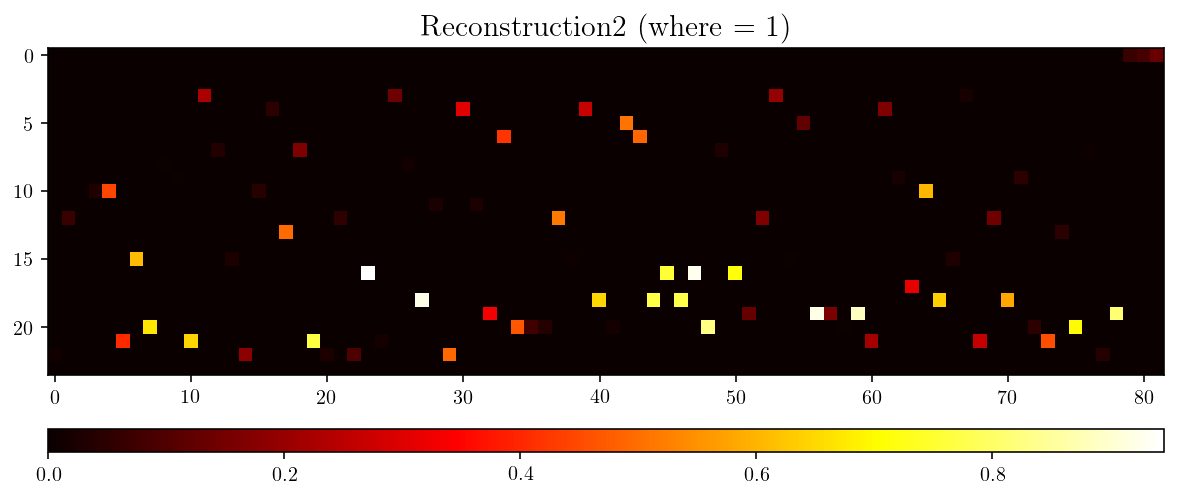

In [66]:
i += 1

print(i)

prot = visualization.Protein(complete_set[i])
recon = visualization.Protein(reconstruction[i])
recon2 = visualization.Protein(reconstruction2[i])

accuracy = (recon.array.argmax(axis=0) == prot.array.argmax(axis=0)).sum() * 100 / 82
accuracy2 = (recon2.array.argmax(axis=0) == prot.array.argmax(axis=0)).sum() * 100 / 82

recon.array[prot.array == 0] = 0
recon2.array[prot.array == 0] = 0

print('Accuracy h=10 : {acc}'.format(acc=accuracy))
print('Accuracy h=2  : {acc}'.format(acc=accuracy2))

recon.plot_sequence(title='Reconstruction10 (where = 1)')
prot.plot_sequence(title='Original')
recon2.plot_sequence(title='Reconstruction2 (where = 1)')

In [30]:
(recon2.array.argmax(axis=0) == prot.array.argmax(axis=0)).sum() * 100 / 82

100.0